![](Rydiqule_Logo_Transparent_300.png)

# Introduction to Rydiqule
**RydIQule**, the Rydberg Interactive Quantum Module, is a python library built to simulate the interaction of Rydberg atoms and light using a semi-classical approach. This notebook will illustrate some of its core functionality, and demonstrate how to use the tool to model simple systems. The intent here is not to demonstrate discoveries in physics. Rather it will use cartoonish but nontrivial examples to demonstrate how to use the module. 

## Design philosophy
Rydiqule was built with a few core principles in mind:

1. **Rydiqule is simple** - Setting and solving an atomic system can be done with just a handful of lines of code while behaving in an intuitive way.
2. **Rydiqule is fast** - Under the hood, the library makes broad use of fast numpy matrix braodcasting and compiled code in places that would be slowed down by native python. The result is a toolbox that can produce meaningful results in a few minutes or less.
3. **Rydiqule is flexible** - Rydiqule can model a huge variety of semiclassical Rydberg atomic systems with no code modification. For users with more particular modelling needs who wish to extend Rydiqule, the `Sensor` class provides a minimal physical system that can easily be inherited and overloaded for more involved experimental setups.

## Limitations
While we have worked hard to make Rydiqule as good as possible, there are some areas that can cause issues:

1. **Memory** - For systems with many laser parameter values, many levels, doppler averaging in several dimensions, or especially a combination of these, the equations of motion generated by rydiqule simply have to be very large, often requiring more memory than is in a typical laptop or simple desktop. For very large systems, the memory footprint may even outpace a powerful workstation. Rydiqule has built-in functionality to handle some of these cases, but it is far from perfect and will need to be iteratated upon to be as flexible as possible.
2. **Speed** - While huge improvements have been made in the speed of `rydiqule`, there are certain situations that  can still cause some slowdowns. For longer simulations, in particular for the poorly-conditioned equations produced with large doppler width, solving can still be slow.
4. **Quantum Back-action** - We treat the optical fields as static, and do not include them explicitly in the semi-classical equations of motion.  Rydiqule does not account for atom-field back-action effects.  This approximation is valid for low optical depth samples, and is known to give valid results for SNR in moderate optical depth samples.  However, for quantitative analysis of quantum noise in high optical depth samples, Rydiqule may not be accurate.
5. **Device Modelling** - Rydiqule is a physics solver, and does not currently have user-friendly support for device-level modelling.

### Imports
Rydiqule is conventionally imported as `rq`. In addition, `numpy` and `matplotlib` are useful to have in notebooks, so we will import them as well. They are dependencies of `rydiqule`, so they should already be installed if you installed rydiqule.

In [1]:
#Auto-reload code for fast testing
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import rydiqule as rq
import numpy as np
import matplotlib.pyplot as plt

---
## 1. Creating a `Sensor` object
The `Sensor` is the core object of rydiqule. It defines an atomic system, and while you can create an solve a Hamiltonian manually, the `Sensor` takes care of the bookeeping to generate Hamiltonian and solve its associated equations of motion. The base `Sensor` class is constructed with a single required argument, the basis size. Here we create a 3-level system. On its own, a `Sensor` contains no information about atomic structure; it is an abstraction that allows for a high degree of manual configuration.

In [3]:
basis_size = 3
sensor = rq.Sensor(basis_size)

### Defining a simple Ladder system
This demonstrates how a minimal ladder system would be defined in `rydiqule`. States are coupled by defining dictionaries which have one key-value pair describing the basis states which are coupled as a tuple with two integer elements. For applied laser fields under the rotating wave approximation, you must also specify a rabi frequency and detuning. They are then added using the `add_couplings()` function with as many couplings as you'd like. All frequency values are in megarad/s.  
### Notes on detunings and rotating wave transformation  
For defining detunings, the states in a coupling are always defined to go from lower to higher energy.  For example, `(1,2)` means state 2 is higher than 1.  Any coupling with a defined `detuning` will be treated in the rotating frame of the coupling.

In [4]:
laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
sensor.add_couplings(laser_01, laser_12)

Once the system is defined, we can see the Hamiltonian matrix. You usually will not need to call this explicitly (it will be called internally by a solver), but it can be useful to make sure the system is defined as expected.

In [5]:
print(sensor.get_hamiltonian())

[[ 0. +0.j  1.5+0.j  0. +0.j]
 [ 1.5-0.j -1. +0.j  2.5+0.j]
 [ 0. +0.j  2.5-0.j -3. +0.j]]


### Defining a simple V scheme
We can do something similar, but with a different arrangement of couplings. We can also pass fields in the constructor if we like

In [6]:
laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_02 = {"states": (0,2), "detuning": 2, "rabi_frequency": 5}
sensor_v = rq.Sensor(3, laser_01, laser_02)
print(sensor_v.get_hamiltonian())

[[ 0. +0.j  1.5+0.j  2.5+0.j]
 [ 1.5-0.j -1. +0.j  0. +0.j]
 [ 2.5-0.j  0. +0.j -2. +0.j]]


### Defining a simple Lambda scheme
Here is another system, this time a lambda scheme.

In [7]:
laser_02 = {"states": (0,2), "detuning": 1, "rabi_frequency": 3}
laser_21 = {"states": (2,1), "detuning": 2, "rabi_frequency": 5}
sensor_lambda = rq.Sensor(3, laser_02, laser_21)

print(sensor_lambda.get_hamiltonian())

[[ 0. +0.j  0. +0.j  1.5+0.j]
 [ 0. +0.j -3. +0.j  2.5-0.j]
 [ 1.5-0.j  2.5+0.j -1. +0.j]]


Before we proceed further, we will make a quick note of what is happening under the hood. `rydiqule` is storing all of the information we specified when we added couplings on an object called a graph from the `networkx` library (https://networkx.org/). We treat the nodes of this graph as states and the edges as couplings. Internally, the graph is called couplings. It is not important to understand `networkx` to use rydiqule, but let's have a look at this `Sensor.couplings` attribute to hopefully help make it a little more transparent.

In [8]:
print(sensor_lambda.couplings.nodes)
print(sensor_lambda.couplings.edges(data=True))

[0, 1, 2]
[(0, 2, {'rabi_frequency': 3, 'detuning': 1, 'phase': 0, 'kvec': (0, 0, 0), 'label': '(0,2)'}), (2, 1, {'rabi_frequency': 5, 'detuning': 2, 'phase': 0, 'kvec': (0, 0, 0), 'label': '(2,1)'})]


The edges contain all of the data that we have added! Again, this is not crucial, but if you are interested in how data is stored, this is a useful demo. 

### Systems that are not fully coupled
We can also define a system in which not all states are connected explicitly by couplings. This allows us to solve systems which, for example, have states coupled only by decoherence. This exact use case will be demonstrated later, but we can set up the system and show the hamiltonian here. 

The hamiltonaian works by treating an uncoupled states as a "second ground state", and calculates digonal hamiltonian elements from there. We show a 4-level system in which state 4 is coupled to state 5 via a steady state rf transition, but to no other states. It should be noted that calling an rf transition does not change the way the system is solved here.

Looking at the hamiltonian, we can see that the 4th term along the diagonal is 0, and the 5th term counts from there.

In [9]:
sensor_uncoupled = rq.Sensor(5)
laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
rf = {"states": (3,4), "detuning": 8, "rabi_frequency": 1}
sensor_uncoupled.add_couplings(laser_01, laser_12, rf)

print(sensor_uncoupled.get_hamiltonian())

[[ 0. +0.j  1.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 1.5-0.j -1. +0.j  2.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  2.5-0.j -3. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5-0.j -8. +0.j]]


In some more complicated cases, we may want a more concrete visual reassurance that everything is defined correctly. `rydiqule` makes use of the `atomic_energy_diagram` library to help draw visual representations of a `Sensor`. In the drawing below, we can see that the diagram indeed shows that states 2 and 3 are not coupled.

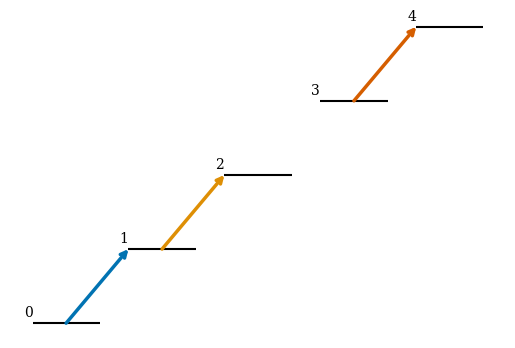

In [10]:
rq.draw_diagram(sensor_uncoupled);

---
## 2. Solving a `Sensor` in the steady-state case
So far we have just created sensor objects and shown their corresponding Hamiltonians. The most important functionality of `rydiqule`, however, is solving their associated equations of motion automatically. Here we will demonstrate some of the ways to solve a simple system using `rydiqule`.

### Basic Solving in the steady state
If all we need steady state behavior of a particular system, it is straightforward and quick in rydiqule. By wrapping a simple matrix differential equation solver, we can quickly get the steady state frequencies of each element of the density matrix $\rho$ of the system. We start by re-defining the same ladder system we had at the beginning of the notebook.

In [11]:
basis_size = 3
sensor = rq.Sensor(basis_size)
laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
sensor.add_couplings(laser_01, laser_12)

#### Gamma matrix

However, before we solve the system, we must define the decoherence and dephasing rates of the system, which is defined by the `gamma_matrix`. This is square matrix whose dimensionality matches that of the system Hamiltonian. Diagonal terms of this matrix represent represent dephasing rates for each state, while off-diagonal terms represent the rate of spontaneous population decay between states. Just like with the rest of rydiqule, the units are in Mrad/s.

This step is crucial. Without a gamma matrix (or with a matrix of all zeros), the equations of motion will be singular, and the system will not have a well-defined steady-state solution.

The gamma matrix is a matrix where each element $\Gamma_{ij}$ defines the incoherent decay rate of atomic population from state $i$ to state $j$.  Diagonal elements $\Gamma_{ii}$ represent incoherend dephasing from state $i$.  More details may be found in Appendix A of https://arxiv.org/abs/2105.10494  

In [12]:
gamma = np.zeros((basis_size, basis_size))
gamma[1,0] = 0.1
sensor.set_gamma_matrix(gamma)

Instead of creating the entire gamma matrix and adding all at once, you can also add individual decoherences using the `add_decoherence` method of `Sensor` as well as the related, specialized helper methods `add_self_broadening` and `add_transit_broadening`.

Here is the equivalent method of defining the gamma matrix for the system using these methods.

In [13]:
sensor.add_decoherence((1,0), 0.1)

Now, instead of showing the Hamiltonian, we can just call `rydiqule.solve_steady_state()` function on `sensor` and get the result.

In [14]:
solution = rq.solve_steady_state(sensor)
print(type(solution))

<class 'rydiqule.sensor_solution.Solution'>


As you can see, the solution itself is not an array, but rather a `rydiqule.Solution` object. This is a bunch-type object that functions just like a python dictionary from which you access values as class variables instead of the ususal `d[key]` syntax. This makes accessing elements a little cleaner. Here we can see that accessing with the usual dictionary key syntax or as a class variable. As you can see below, they are the same. 

In [15]:
print(solution.rho)
print(solution["rho"])

[-0.17354416 -0.24474176  0.00800973  0.24029191  0.20024326  0.00667478
  0.          0.22694236]
[-0.17354416 -0.24474176  0.00800973  0.24029191  0.20024326  0.00667478
  0.          0.22694236]


#### Adjustments to the equations
So why does the solution have 8 elements? Why is it real? It represents a density matrix, which should have $n^2$ complex-valued elements ($3^2=9$ in this case). 

For numerical stability, `rydiqule` removes the ground state population equations, so the $\rho_{00}$ term is omitted from the solution (typically $\rho_{00} >> \rho_{ij}$ for $ij \neq 00$, which is the source of the numerical problems). If needed, it can be inferred as $\rho_{00} = 1 - \sum_{i=1}^{n} \rho_{ii}$. Furthermore, rydiqule transforms the basis so that all values are real. Rather than an $n\times n$ Hermitian matrix, `rydiqule` parameterizes the density matrix $\rho$ as $n\times n$ real values before removing the ground state. For more details, refer to the documentation of the `get_basis_transformation()` function in the `sensor_utils` module.

So how do we know (ideally quickly) which element of the solution corresponds to which density matrix element? The `Sensor` class contains a function called `basis()` which does exactly this, returning a list of strings showing the info we want. Since the density matrix is hermitian and trace 1, this array does indeed contain all of the information of the density matrix.  Note that `basis()` does not include $\rho_{00}$ since the ground state is removed by the solver (see docs)

In [16]:
print(sensor.basis())

['01_real' '02_real' '01_imag' '11_real' '12_real' '02_imag' '12_imag'
 '22_real']


*Note*: there are technically arguments to disable this and solve the full complex equations, but they are intended for internal use only, and almost certainly will not work for a general system. We recommend keeping these values at their defaults.

---
### Solving for multiple values of a parameter
Getting a single result is nice, but really just a single data point. One of the simplest types of experiments you might want to simulate is to scan, for example, over a range of detuning values and see the behavior of the system at each value. Fortunately, `rydiqule` makes this type of experiment trivial. Suppose we wanted to sweep our probe laser detuning between -10 MHz and 10 MHz. Without `rydiqule` we might write an explicit loop over a set of values, modifying and solving the system at each iteration, and storing the results in a new list. In python especially, this sort of approach has a high computational overhead. With `rydiqule`, We can set up the system similarly to above, this time as a 4-level system. However, this time, instead of using a single `float` value for a coupling parameter, we will define the $0\leftrightarrow 1$ coupling detunuing value as a list-like object, in our case a 1-dimensional numpy array constructed with the `linspace` function.

In [17]:
basis_size = 4
sensor_sweep = rq.Sensor(basis_size)

detunings = 2*np.pi*np.linspace(-10,10,201) #201 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3}
coupling = {"states":(1,2), "detuning": 0, "rabi_frequency": 5}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7}

sensor_sweep.add_couplings(probe, coupling, rf)

sensor_sweep.add_decoherence((1,0), 0.1)
sensor_sweep.add_decoherence((2,1), 0.1)
sensor_sweep.add_decoherence((3,0), 0.1)

From here, we solve exactly as before. Rydiqule will automagically solve the system for every detuning value (very quickly). We also show the utility function `get_rho_ij()` which extracts $\rho_{ij}$ from the density matrix $\rho$ of any solution (regardless of how many dimensions it is). We use it to get $\rho_{01}$.

In [18]:
solution = rq.solve_steady_state(sensor_sweep)
print(f"Solution shape: {solution.rho.shape}")
absorption = rq.get_rho_ij(solution.rho,0,1).imag
print(f"Absorption_shape: {absorption.shape}")

Solution shape: (201, 15)
Absorption_shape: (201,)


We can see that there is a 15-element solution for each one of the detuning values. After we get the absorption using `get_rho_ij()`, we can see that we are left with a single array with 201 elements, corresponding to to the absorption at each value of detuning. The function doesn't do anything special, it just is a quick way to get common info you might want out of a solution. We can now do a quick-and-dirty plot to see what it looks like:

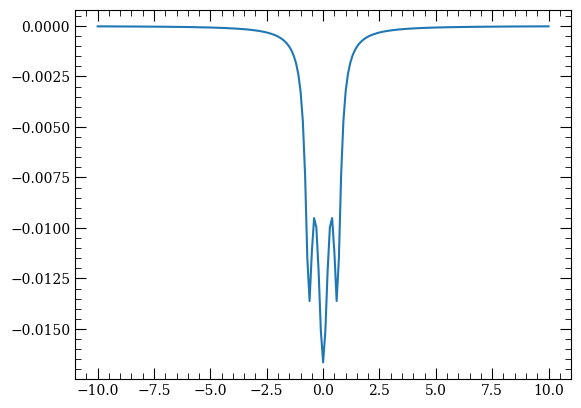

In [19]:
plt.plot(detunings/2/np.pi, absorption);

### Solving for multiple values of multiple parameters
If you like the simplicity of scanning an single laser detuning in `rydiqule` you will be even more excited to learn that rydiqule can handle scans over multple different parameters simulataneously. We will set up the sensor as before, with a couple of changes. We will now also scan the dephasing rate and show how the absorption changes.

In [20]:
basis_size = 4
sensor_sweep_2 = rq.Sensor(basis_size)

detunings = 2*np.pi*np.linspace(-10, 10, 201) #201 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3, "label":"probe"}
coupling = {"states":(1,2), "detuning": 0, "rabi_frequency": 5, "label": "coupling"}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7, "label": "rf"}

sensor_sweep_2.add_couplings(probe, coupling, rf)

gamma10 = np.linspace(0.1, 1.0, 10)
sensor_sweep_2.add_decoherence((1,0), gamma10)
sensor_sweep_2.add_decoherence((2,1), 0.1)
sensor_sweep_2.add_decoherence((3,0), 0.1)

Once again, no extra steps are required, just call `solve_steady_state()` as normal, and look at the shape of the solution and the absorption and rydiqule will quickly find the solution for every combination of those 2 parameters.

In [21]:
solution_2 = rq.solve_steady_state(sensor_sweep_2)
print(f"Solution shape: {solution_2.rho.shape}")
absorption_2 = rq.get_rho_ij(solution_2.rho,0,1).imag
print(f"Absorption_shape: {absorption_2.shape}")

Solution shape: (201, 10, 15)
Absorption_shape: (201, 10)


How do we know which axis corresponds to the probe detuning and which is the coupling detuning? `Sensor` has a method called `axis_labels()` which does just that, and this is where labeling our couplings comes in handy. Note that if couplings are not labeled, the axes will default to being labeled by the states they couple. For example `["(0,1)_detuning", (1,2)_detuning"]`.

This function will not label the axes for the density matrix, or the time or doppler axes (discussed later), since it is just a method of `Sensor`. The density matrix will always be last, time second to last (if solved in the time domain), and the axes for *n* dimensions of doppler solveing will be the first *n* axes.

In [22]:
print(sensor_sweep_2.axis_labels())

['probe_detuning', '(1,0)_gamma']


So the first axis corresponds to the probe laser detuning, and the second axis corresponds to $\Gamma_{1,0}$. Now calling a function like `np.argmin()` or `np.argmax()` could quickly be used to optimize some value over a large parameter space. `rydiqule` lets us add as many parameters as you like as a list, detunings, rabi frequencies, or dephasings. It's handy, but beware that the memory footprint can quickly balloon out of control when generating equations of motion if you get too ambitious, increasing by a factor of $n$ when you add an axis with $n$ elements, especially given that many values used in internal calculations are 128-bit complex arrays. Currently, `rydiqule` has internal functions to spot this before it happens and break it into more manageable chunks if it can, but it is certainly possible to make a system which even it cannot handle. If the solution does not fit in memory, no amount of splitting up the equations will allow the system to be solved, and you should reconsider the size of your parameter space. Even in the above example, `rydiqule` is solving $201\times 10\times15\approx 30000$ equations simultaneously.

We can plot these probe sweeps at the same time fairly simply.

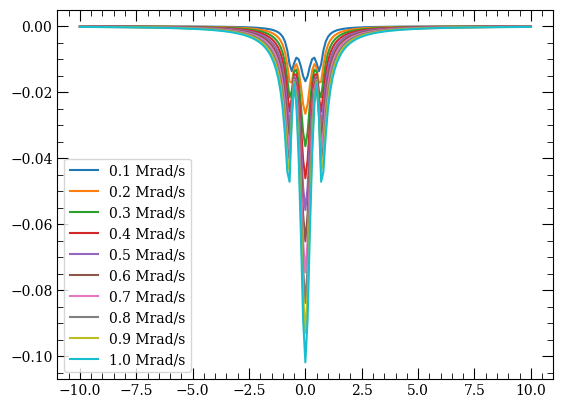

In [23]:
fig, ax = plt.subplots(1)

for i in range(absorption_2.shape[1]):
    ax.plot(detunings/2/np.pi, absorption_2[:,i], label=f'{gamma10[i]:.1f} Mrad/s')
    
ax.legend();

---
## 3. Solving in the time domain
Suppose you have defined a sensor, and we want to see the response of the sensor of some well-defined rf input function. In this case, the steady-state solution above is not enough. We will set up a sensor similar to the one above, but define the rf field differently. We will use the `"time_dependence"` keyword in the dictionary, and supply with a function which takes a single argument of time in microseconds. First we will define a function below, which turns on a static field at $t=1\mu s$. 

In [24]:
def turn_on_field(t):
    if t < 1:
        return 0.0
    else:
        return 1.0

`rydiqule` treats time dependent functions as a modulation of the rabi frequency at time *t*. So if we define the field we apply this function to as having a rabi frequency of 7 Mrad/s as above, the field will turn on with a rabi frequency of 7 Mrad/s at $t=1$. Note that because we are still specifying a detuning, the field is still treated as being in the rotating frame. 

*Note*: Specifying time dependence means you can no longer call `solve_steady_state()`

In [25]:
basis_size = 4
sensor_time = rq.Sensor(basis_size)

probe = {"states":(0,1), "detuning": 2, "rabi_frequency": 3, "label":"probe"}
coupling = {"states":(1,2), "detuning": 2, "rabi_frequency": 5, "label": "coupling"}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7, "label": "rf", "time_dependence":turn_on_field}

sensor_time.add_couplings(probe, coupling, rf)

gamma = np.zeros((basis_size, basis_size))
gamma[1:,0] = 0.1
sensor_time.set_gamma_matrix(gamma)

With everything set up, we now call the `rq.solve_time()` function, which behaves as you might expect. The only difference is that you need a couple of extra arguments:
- `end_time`, specifying the length of the simulation time in microseconds.
- `num_pts`, which specifies the number of points on the time interval $(0,t_{end})$ at which to sample the solution evenly. 

In addition, the function can take the optional argument `use_nkode` which is a `bool` that indicates whether to use the `numbakit_ode` compiled differential equation solver as a backend. This can result in speedups in some situations, particularly very long time simulation ($\approx >100 \mu s$ or so). However, it introduces overhead with compiling input functions that means it is not guaranteed to provide a speedup so it defaults to `False`. Because its speed vs the default `scipy.optimize.solve_ivp()` backend is highly dependent on the particular problem, and even version/platform to a certain extent, our recommendation is to experiment with both `True` and `False` to see what works best for the types of problems you need to solve.

In [26]:
end_time = 10 #microseconds
num_pts = 100

solution_time = rq.solve_time(sensor_time, end_time, num_pts)
print(type(solution_time))

<class 'rydiqule.sensor_solution.Solution'>


Once again we have a `Solution` object. However, for a time solve, this object contains two fields, `rho` as before, and now also `t`, which are the time values at which the solution was evaluated. Let's have a look at the shape of each one.

In [27]:
print(f"Solution shape: {solution_time.rho.shape}")
print(f"t shape: {solution_time.t.shape}")

Solution shape: (100, 15)
t shape: (100,)


So the density matrix solution is an array of shape `(100, 15)`. The 15 is obviously the flattened real density matrix discussed above ($4^2-1 = 15$) and, as you might expect, the 100-element axis represents the time. So accessing `solution_time.rho[50,:]` or just `solution_time.rho[50]` would give the density matrix of the system at time given by the $50th$ element of `solution_time.t[50]`.

Now, we can look at what a particular density matrix element looks like as a function of time using matplotlib. This will be a minimal plot of $\rho_{01}$ vs $t$ just to show how you might do this for your own system. The `get_rho_ij` function makes it easy, since the axis for the density matrix is always the last one for any `rydiqule` solution.

Shape: (100,)


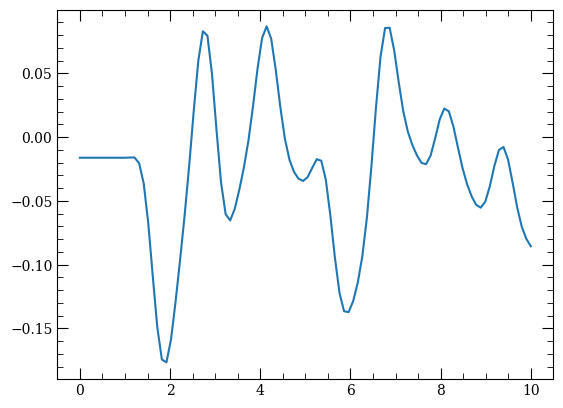

In [28]:
absorption_time = rq.get_rho_ij(solution_time.rho,0,1).imag
print(f"Shape: {absorption_time.shape}")

plt.plot(solution_time.t, absorption_time);

As we can see, the density matrix element is in a steady-state until the field is turned on at time $t=1\mu s$, then we observe oscilitory behavior after the field is turned on. This is a toy model, so more detailed discussion of results will be saved for other notebooks, but you can see that viewing this behavior is very straightforward once the system has been solved.

### Initial Conditions
You might reasonably ask where the steady-state that is on at $t=0$ comes from in the above example. If the initial condition of the time solve is unspecified, `rydiqule` will solve the steady-state problem *without* any of the time-dependent fields active and use that as the initial condition for the solver. However, if you wish to start the system with a different initial density matrix, you can specifiy the optional `init_cond` argument in `solve_time()`. As a note, the shape of the initial condition must match what the shape of the steady-state solution is (if you wish to use different initial conditions for each set of parameters), or just the shape of the density matrix (to use the same initial condition for all cases). For this system, they are the same since there is only one value for each laser parameter, but in general they need to match.

Let us see what it looks like to set the initial condition to all the population staying in the ground state. This corresponds to $\rho_{00}=1$, and $\rho_{ij} = 0$ for $i,j \neq 0,0$. Since we know `rydiqule` discards the ground state when it solves, this corresponds to an array of all zeros.

In [29]:
sol_dim = sensor_time.basis_size**2 - 1
ic = np.zeros(sol_dim)
print(f"Initial Condition Shape: {ic.shape}")

Initial Condition Shape: (15,)


Notice that we also accessed the size of the basis via `Sensor.basis_size`. This is the expected size for a solution, so let's see what the solution looks like for the absorption element $\rho_{01}$. 

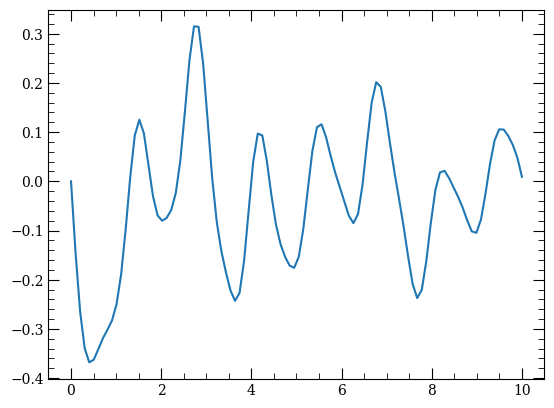

In [30]:
solution_time_from_0 = rq.solve_time(sensor_time, end_time, num_pts, init_cond=ic)
absorption_time_from_0 = rq.get_rho_ij(solution_time_from_0.rho, 0, 1).imag

plt.plot(solution_time_from_0.t, absorption_time_from_0);

As you might expect, we see an abrupt transient from zero, which has a small jump at $1 \mu s$, followed by some oscillitory behavior that is at least similar to the plot above.

### Multi-value Parameters in a time solve
Just like `solve steady`, `solve_time` supports coupling parameter definitions that are list-like. It works more or less as you might expect based on the behavior of steady-state solving, but it is worth briefly discussing for the sake of demonstrating what the solution might look like.

We start by creating a sensor identical to the one above, but with detunings defined as lists:

In [31]:
basis_size = 4
time_sensor_sweep = rq.Sensor(basis_size)

detunings = 2*np.pi*np.linspace(-10,10,51) #51 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3, "label":"probe"}
coupling = {"states":(1,2), "detuning": detunings, "rabi_frequency": 5, "label": "coupling"}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7, "label": "rf", "time_dependence":turn_on_field}

time_sensor_sweep.add_couplings(probe, coupling, rf)

gamma = np.zeros((basis_size, basis_size))
gamma[1:,0] = 0.1
time_sensor_sweep.set_gamma_matrix(gamma)

Then, we solve with `solve_time` just as above. We have reduced the number of detunings, but remember that `rydiqule` is still solving about 2,500 equations here, so we should expect it to be a little slow. We can use the `%%time` jupyter magic to see how slow.

In [32]:
%%time
end_time = 10 #microseconds
num_pts = 100

solution_time_sweep = rq.solve_time(time_sensor_sweep, end_time, num_pts)

CPU times: total: 39.9 s
Wall time: 20.4 s


On my machine it runs in about 7 seconds, but the time depends on several things, including how powerful your machine is and library version/build issues we are working on. If it takes you several times longer, consider trying with `use_nkode=True`. We can now inspect and try and make sense of the shape of the solution.

In [33]:
print(f"Shape: {solution_time_sweep.rho.shape}")

Shape: (51, 51, 100, 15)


So what does this mean? As you likely can figure out, the last axis of the solution is still the elements of the density matrix with the expected 15 elements. Then, the second-to-last axis is the time axis. This holds true in general for time solutions regardless of how many other axes there are. The last is always density matrix elements and the second-to-last is always time. We can then get the other axes from a call to `Sensor.axis_labels()`, which works just as above to help with the rest of the axes.

In [34]:
print(time_sensor_sweep.axis_labels())

['probe_detuning', 'coupling_detuning']


`get_rho_ij()` also works as expected for stacked time solutions:

In [35]:
absorption = rq.get_rho_ij(solution_time_sweep.rho, 0, 1).imag
print(absorption.shape)

(51, 51, 100)


So suppose we wanted to plot $\rho_{01}$ vs $t$ for the on-resonance case. On-resonance (detuning zero) corresponds to the middle of the detuning list defined above, element 25. We can then plot that vs time.

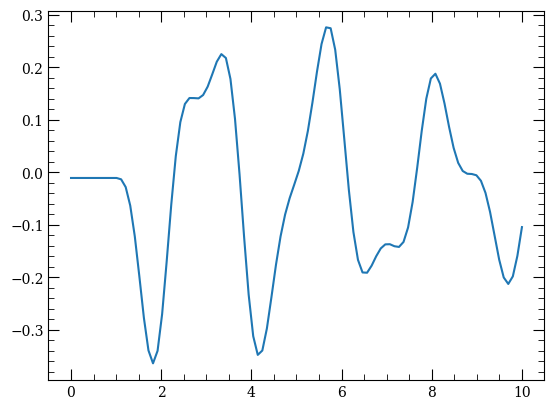

In [36]:
absorption_resonance = absorption[25, 25]
plt.plot(solution_time_sweep.t, absorption_resonance);

## 4. Simulating Doppler broadening
One final key piece of functionality in `rydiqule` is the ability to simulate a doppler-broadened system. Internally, this is handled by breaking a doppler velocity profile into some number of slices, then applying the corresponding detunings for each class to the unshifted solution. This produces many sets of equations of motion, which are then solved, and then a weighted average performed to get the doppler-broadened solution.

To set up a system with doppler broadening, we use the `"kvec"` keyword the couplings definition. A `kvec` is a 3-element spatial vector in the propagation direction of the field, with magnitude equal to the standard deviation of the doppler velocity profile component in that direction.

In [37]:
basis_size = 4
sensor_doppler = rq.Sensor(basis_size)

width = 2*np.pi*0.1 #Mrad/s
k_direction = np.array([1,0,0])

detunings = 2*np.pi*np.linspace(-10,10,201) #201 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3, 'kvec': k_direction*width}
coupling = {"states":(1,2), "detuning": 0, "rabi_frequency": 5, 'kvec': k_direction*width}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7}

sensor_doppler.add_couplings(probe, coupling, rf)

gamma = np.zeros((basis_size, basis_size))
gamma[1:,0] = 0.1
sensor_doppler.set_gamma_matrix(gamma)

Again, this is a cartoon example, but it illustrates how to set up doppler broadening. In this case, we apply identical 100 Mhz doppler broadening in the x direction on both the coupling and probe lasers. With the lasers configured, we can now call the `solve_steady_state()` function to solve as before, this time with the optional argument `doppler=True`.

In [38]:
solution_doppler = rq.solve_steady_state(sensor_doppler, doppler=True)
print(f"Solution shape: {solution_doppler.rho.shape}")

Solution shape: (201, 15)


Note that by default, the solution shape is the same as it was without doppler. `rydiqule` performs a weighted average of the solutions for each doppler slice. This behavior can be disabled with the optional `sum_doppler=False` flag. In this case, the wighted solution to each doppler class will be returned so they can be inspected.

Absorption_shape: (201,)


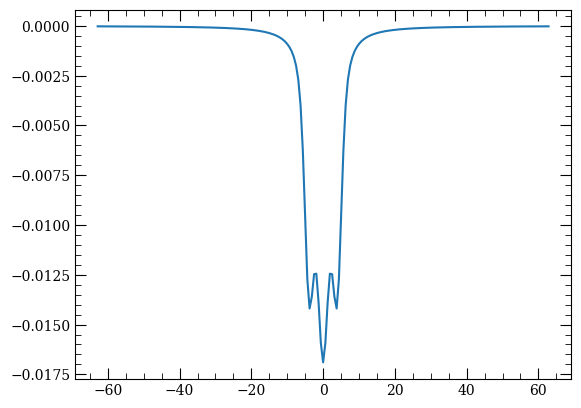

In [39]:
absorption_doppler = rq.get_rho_ij(solution_doppler.rho,0,1).imag
print(f"Absorption_shape: {absorption_doppler.shape}")

plt.plot(detunings, absorption_doppler)

Notice that apart from the doppler broadening, this system is identical to the first one we solved over a range of detunings. Now, with the doppler broadening, its features have been smeared out a little as expected with a doppler distribution.

It is also worth mentioning that the same argument works identically in the `solve_time()` function.

## 5. `Cell` and real atoms
So far all of the functionality shown so far have used the `Sensor` object, providing the barebones physics needed to run simulations. However, in an applied setting, we would like to avoid manually filling all these parameters in with the properties of real atoms. Thus, we have created the `Cell` class, which inherites `Sensor`. This inheritence structure means that a `Cell` uses all the same functions as `Sensor`, in our case with some extra bells and whistles. First, and most importantly, we can specify a physical atom to associate with the sensor. This (behind the scenes) automatically fills in things like state lifetimes and transition frequencies.

The first argument one can specify a particluar Rydberg atom isotope via one of the following strings: `['H', 'Li6', 'Li7', 'Na', 'K39', 'K40', 'K41', 'Rb85', 'Rb87', 'Cs']`, corresponding respecively to Hydrogen-1, Lithium-6, Lithium-7, Sodium-23, Potassium-39, Potassium-40, Potassium-41, Rubidium-85, Rubidium-87, and Caesium-133. After the atom, the next arguments are sequence of atomic states formatted with the Quantum numbers `[n, l, j, m]`. Finally, this is where experimental parameters are defined in order to calculate system observables (such as optical path length and beam_area). If we wanted to create a `Cell` with the D1 line of the Rubidium atom for example, we might do the following:

In [40]:
Rb_Cell = rq.Cell('Rb85', [5, 0, 1/2, 1/2], [5, 1, 1/2, 1/2], cell_length=1e-3, beam_area=1e-6)

Of course, it might get tedious to add common transitions like D1 and D2, so Rydiqule adds a shorthand for calculating them, `D1_states` and `D2_states`. These can be specified either with a principle quantum number `n`, or with one of the strings we use to specify the atom (additionally, the non-isotope-specified chemical symbol can be used, such as `"Rb"`).

In [41]:
print(rq.D1_states('Rb85'))
print(rq.D2_states(5))

([5, 0, 0.5, 0.5], [5, 1, 0.5, 0.5])
([5, 0, 0.5, 0.5], [5, 1, 1.5, 0.5])


Using this method, the cell can be created as follows:

In [42]:
atom = 'Rb85'
Rb_Cell = rq.Cell(atom, *rq.D1_states(atom))

So we have created out cell, but how can we be sure what states are in the system? We can use the `Cell.states_list()` function.

In [43]:
print(Rb_Cell.states_list())

[[5, 0, 0.5, 0.5], [5, 1, 0.5, 0.5]]


These are the 2 states we are considering in our `Cell`, formatted with the quantum numbers `[n, l, j, m]`. As you can see, they do indeed correspond to the D1 line of Rubidium-85. But what if we wanted to add more states? Additional states can be defined as part of the system, but must be declared when the `Cell` is created. Let's add something in a higher state $n=20$.

In [44]:
atom = 'Rb85'
new_state = [20, 0, 0.5, 0.5]
Rb_Cell = rq.Cell(atom, *rq.D1_states(atom), new_state)

Importantly, while the constructor is a little, different, it is still a `Sensor` under the hood, we just no longer need to specify transition frequencies and decoherences manually (although decoherences can still be added further if desired). As such we can call all the usual sensor functions, and all the information is still stored on the `couplings` attribute of `Cell`.

Additional self-broadening terms can be added to the decoherence matrix using the usual methods. Note that to make a new decoherence additive rather than overriding something, give it a unique label.

In [45]:
gamma_collisional = 2*np.pi*1.0 #radMHz
Rb_Cell.add_self_broadening(1, gamma_collisional, label="collisional")
print(Rb_Cell.decoherence_matrix())

[[4.11728555e-01 0.00000000e+00 0.00000000e+00]
 [3.65262306e+01 6.28318531e+00 0.00000000e+00]
 [5.51030221e-01 2.69737753e-02 0.00000000e+00]]


So we now have a 3-level system with the expected states, so far so good. And it even generated a gamma matrix based on state lifetimes! From here we can add couplings as before.    
Be aware that when using `Cell`, if `detuning` is not specified, the Hamiltonian will be written in the laboratory frame and the frequency of the transition will be calculated automatically.  This can lead to very large frequencies in the Hamiltonian,

In [46]:
detunings = 2*np.pi*np.linspace(-10,10,201) #201 values between -10 and 10 MHz
laser_01 = {"states": (0,1), "detuning": detunings, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
Rb_Cell.add_couplings(laser_01, laser_12)

To drive home that this really is just a sensor, let's have a look at the `couplings` attribute.

In [47]:
print(Rb_Cell.couplings.nodes(data=True))
print(Rb_Cell.couplings.edges(data=True))

[(0, {'qnums': [5, 0, 0.5, 0.5], 'energy': 0, 'gamma_lifetime': 0}), (1, {'qnums': [5, 1, 0.5, 0.5], 'energy': 2369435838.3044744, 'gamma_lifetime': 36.11450209100816}), (2, {'qnums': [20, 0, 0.5, 0.5], 'energy': 6273525803.532067, 'gamma_lifetime': 0.16627544164097147})]
[(0, 0, {'gamma_transit': 0.41172855461658464, 'label': '(0,0)'}), (0, 1, {'rabi_frequency': 3, 'detuning': array([-62.83185307, -62.20353454, -61.57521601, -60.94689748,
       -60.31857895, -59.69026042, -59.06194189, -58.43362336,
       -57.80530483, -57.1769863 , -56.54866776, -55.92034923,
       -55.2920307 , -54.66371217, -54.03539364, -53.40707511,
       -52.77875658, -52.15043805, -51.52211952, -50.89380099,
       -50.26548246, -49.63716393, -49.0088454 , -48.38052687,
       -47.75220833, -47.1238898 , -46.49557127, -45.86725274,
       -45.23893421, -44.61061568, -43.98229715, -43.35397862,
       -42.72566009, -42.09734156, -41.46902303, -40.8407045 ,
       -40.21238597, -39.58406744, -38.9557489 , -38

There is a **lot** more information, but the structure is identical. The only difference is that values like decoherences from natural state lifetimes have been added automatically. If we added states without the RWA, transition frequencies would be added automatically as well, since "absolute energy" (energy difference with the ground state) is stored on the nodes. Given that it is the same as any other `Sensor`, let's show that by solving the system as we would have before, then we can call it a day!

In this case, we can easily call a convenience function, `Solution.get_transmission_coef()` to return the transmission coefficient for the calculated solution(s).

C:\Users\David\src\Rydiqule\src\rydiqule\sensor_solution.py:223: UserWarning: At least one solution has optical depth greater than 1. Integrated results are likely invalid.
  warnings.warn(('At least one solution has optical depth '


Text(0, 0.5, 'transmission coefficient')

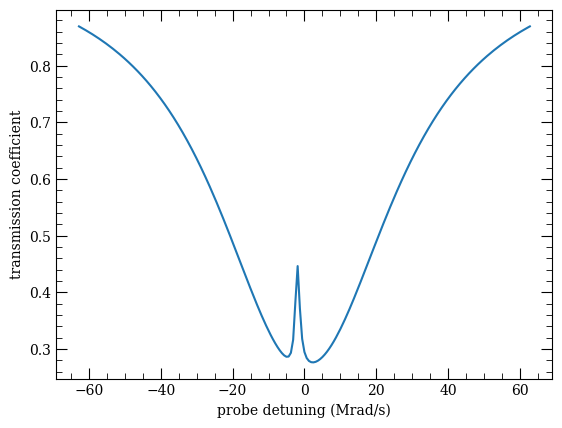

In [48]:
sol = rq.solve_steady_state(Rb_Cell)
absorption_cell = sol.get_transmission_coef()
plt.plot(detunings, absorption_cell)
plt.xlabel('probe detuning (Mrad/s)')
plt.ylabel('transmission coefficient')

This is a very minimal example introducing the concept of the `Cell` class as an extension of `Sensor`. For a more detailed example of its use, other notebooks make heavy use of the `Cell` to do meaningful physics. It also illustrates that `Sensor` is extensible, which actually has some very helpful implications for what you can do with `rydiqule`. `Sensor`, or even `Cell`, can be extended further to model very specific experimental setups so they can be re-created easily, specifying only the parameters that are likely to change. If you are comfortable with object-oriented programming in python, the sky is the limit in terms of what you can store on the `couplings` graph and what you can calculate automatically. From here, feel free to play around with other notebooks, and use `rydiqule` for your own problems! We are constantly trying to improve the library, so feedback is welcome.

## Acknowledgments ##

The authors recognize financial support from the US Army and Defense Advanced Research Projects Agency (DARPA). Rydiqule has been approved for unlimited public release by DEVCOM Army Research Laboratory and DARPA.  This software is released under the xx licence through the University of Maryland Quantum Technology Center.  The views, opinions and/or findings expressed here are those of the authors and should not be interpreted as representing the official views or policies of the Department of Defense or the U.S. Government.

In [49]:
rq.about()


        Rydiqule
    
Rydiqule Version:     1.1.0
Installation Path:    ~\src\Rydiqule\src\rydiqule

      Dependencies
    
NumPy Version:        1.23.4
SciPy Version:        1.9.3
Matplotlib Version:   3.6.2
ARC Version:          3.3.0
Python Version:       3.8.15
Python Install Path:  C:\Miniconda3\envs\arc
Platform Info:        Windows (AMD64)
CPU Count:            4
Total System Memory:  16 GB
